In [2]:
import pandas as pd
import polars as pl
import numpy as np
import duckdb
import time

# Análisis

In [2]:
data = pd.read_csv('..\..\src\Competencia 01\competencia_01_crudo.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978439 entries, 0 to 978438
Columns: 154 entries, numero_de_cliente to Visa_mpagominimo
dtypes: float64(89), int64(65)
memory usage: 1.1 GB


In [3]:
data.head()

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo
0,249221323,202101,1,0,0,46,93,3070.24,15691.10,1278.11,...,0.0,4.0,0.00,-20833.47,0.0,2814.0,6743.38,6.0,0.0,9559.95
1,249227600,202101,1,0,0,42,278,496.21,15321.80,418.97,...,0.0,11.0,13267.49,-9662.51,0.0,5541.0,9419.90,8.0,0.0,1900.26
2,249234235,202101,1,0,0,54,17,806.56,10549.80,174.26,...,0.0,4.0,0.00,-4692.00,0.0,577.0,2821.32,2.0,0.0,6885.51
3,249244449,202101,1,0,0,61,290,27485.71,65621.74,23590.68,...,0.0,25.0,23800.17,-20349.22,0.0,7916.0,23509.71,8.0,0.0,1219.92
4,249244739,202101,1,0,0,66,320,3306.82,48787.99,3274.95,...,0.0,4.0,0.00,-88178.37,0.0,1958.0,20397.54,8.0,0.0,2627.52


In [4]:
# Listo las columnas
print(data.columns.tolist())

['numero_de_cliente', 'foto_mes', 'active_quarter', 'cliente_vip', 'internet', 'cliente_edad', 'cliente_antiguedad', 'mrentabilidad', 'mrentabilidad_annual', 'mcomisiones', 'mactivos_margen', 'mpasivos_margen', 'cproductos', 'tcuentas', 'ccuenta_corriente', 'mcuenta_corriente_adicional', 'mcuenta_corriente', 'ccaja_ahorro', 'mcaja_ahorro', 'mcaja_ahorro_adicional', 'mcaja_ahorro_dolares', 'cdescubierto_preacordado', 'mcuentas_saldo', 'ctarjeta_debito', 'ctarjeta_debito_transacciones', 'mautoservicio', 'ctarjeta_visa', 'ctarjeta_visa_transacciones', 'mtarjeta_visa_consumo', 'ctarjeta_master', 'ctarjeta_master_transacciones', 'mtarjeta_master_consumo', 'cprestamos_personales', 'mprestamos_personales', 'cprestamos_prendarios', 'mprestamos_prendarios', 'cprestamos_hipotecarios', 'mprestamos_hipotecarios', 'cplazo_fijo', 'mplazo_fijo_dolares', 'mplazo_fijo_pesos', 'cinversion1', 'minversion1_pesos', 'minversion1_dolares', 'cinversion2', 'minversion2', 'cseguro_vida', 'cseguro_auto', 'csegur

<Axes: >

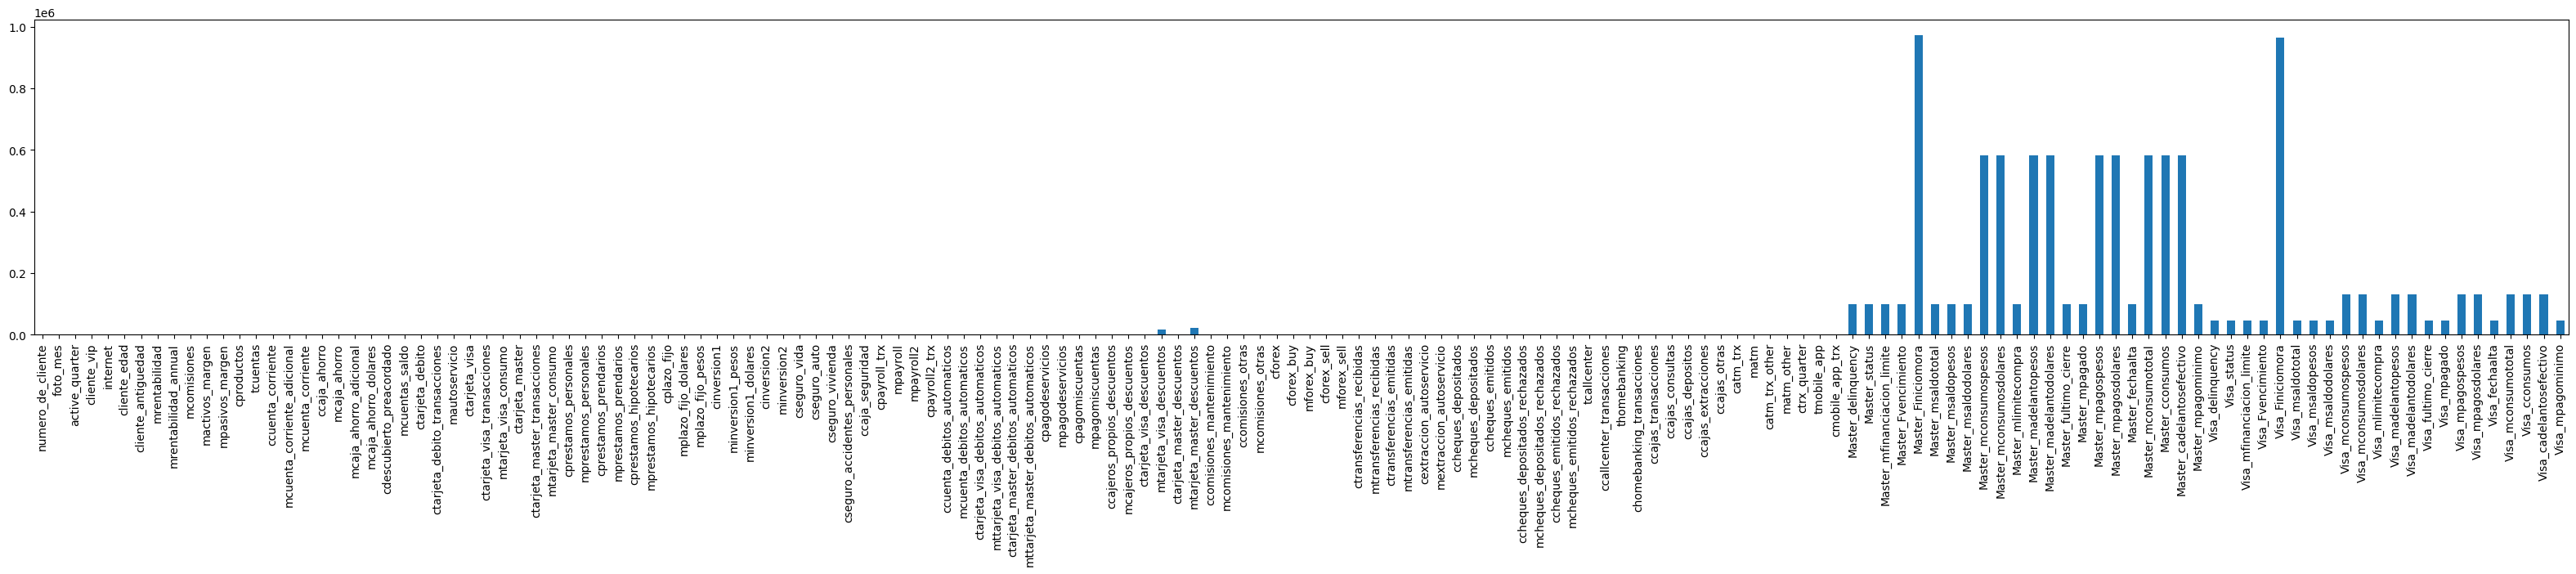

In [5]:
# Valores faltantes
data.isna().sum().plot(kind='bar', figsize=(40, 5))

In [6]:
# Clientes únicos
len(data["numero_de_cliente"].unique())

168881

In [7]:
# Meses únicos
data["foto_mes"].unique()

array([202101, 202102, 202103, 202104, 202105, 202106])

In [8]:
# Cantidad de clientes VIP
data["cliente_vip"].value_counts()

cliente_vip
0    975533
1      2906
Name: count, dtype: int64

# Clientes que cambiaron su estado VIP

In [9]:
# Me fijo de forma general si hay clientes que fueron VIP y ahora no lo son, o viceversa
data.groupby("numero_de_cliente")["cliente_vip"].transform(lambda x: x.nunique()).value_counts()

cliente_vip
1    974627
2      3812
Name: count, dtype: int64

In [10]:
# Ordenamos los datos por cliente y fecha
data_ordenada = data.sort_values(by=["numero_de_cliente", "foto_mes"])

# Obtenemos el estado VIP anterior para cada cliente
estado_anterior = data_ordenada.groupby("numero_de_cliente")["cliente_vip"].shift()
# Alternativamente se podría usar esto pero es más lento: data_ordenada.groupby("numero_de_cliente")["cliente_vip"].transform(lambda x: x.shift())

# Marcamos cambio solo cuando hay un valor anterior Y es diferente al actual
data_ordenada['cambio_vip'] = (estado_anterior != data_ordenada["cliente_vip"]) & estado_anterior.notna()

In [11]:
estado_anterior

0         NaN
161527    0.0
323682    0.0
486791    0.0
650209    0.0
         ... 
978434    NaN
978435    NaN
978436    NaN
978437    NaN
978438    NaN
Name: cliente_vip, Length: 978439, dtype: float64

In [12]:
data_ordenada["cambio_vip"].value_counts()

cambio_vip
False    977776
True        663
Name: count, dtype: int64

In [13]:
data_ordenada.loc[data_ordenada['cambio_vip']==True]

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,cambio_vip
814496,250879176,202106,1,1,0,48,269,2875.28,40914.21,720.83,...,0.0,0.00,-36762.93,0.0,5314.0,28798.62,3.0,0.0,2216.97,True
814518,250991926,202106,1,1,0,74,298,-64.30,-6252.10,487.90,...,0.0,0.00,-39910.58,0.0,4945.0,15899.39,6.0,0.0,4738.92,True
814690,251802073,202106,1,1,0,62,325,22294.91,178361.42,1619.49,...,21.0,4136.38,-6490.86,0.0,8870.0,4027.78,1.0,0.0,258.06,True
814697,251830143,202106,1,1,0,46,281,14384.72,66357.05,6724.94,...,0.0,0.00,-23185.47,0.0,8067.0,6150.03,2.0,0.0,8844.42,True
162153,252040537,202102,1,0,0,69,374,1497.70,48851.86,1048.97,...,4.0,0.00,-1175.89,0.0,4829.0,746.07,2.0,0.0,82.11,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964679,1286848450,202106,1,1,0,51,26,2289.71,69066.97,2409.30,...,0.0,0.00,NaN,NaN,344.0,NaN,NaN,NaN,0.00,True
970556,1358522551,202106,1,1,0,44,34,-10720.99,443089.50,7041.23,...,0.0,0.00,-330598.32,0.0,839.0,6147.34,2.0,0.0,66978.30,True
971310,1387964591,202106,1,1,0,42,32,157010.63,1587247.56,-3356.25,...,0.0,0.00,-17804.94,0.0,210.0,69784.65,3.0,0.0,5184.66,True
971849,1415612262,202106,1,1,0,42,28,2472.30,144754.38,0.00,...,0.0,0.00,-10399.82,0.0,703.0,-23.67,2.0,0.0,1466.25,True


In [14]:
data_ordenada.loc[data_ordenada["numero_de_cliente"]==250879176,["numero_de_cliente", "foto_mes", "cliente_vip", "cambio_vip"]]

,numero_de_cliente,foto_mes,cliente_vip,cambio_vip
373,250879176,202101,0,False
161900,250879176,202102,0,False
324054,250879176,202103,0,False
487162,250879176,202104,0,False
650579,250879176,202105,0,False
814496,250879176,202106,1,True


# Analisis de antiguedad

In [15]:
# Calculo la diferencia de antiguedad de los clientes
antiguedad = data_ordenada.groupby("numero_de_cliente")["cliente_antiguedad"].diff().fillna(0)

# La antiguedad tendría que ser 1 (0 para la primer fila de cada cliente). Valores mayores o menores indican problemas
antiguedad.value_counts()

cliente_antiguedad
 1.0     809545
 0.0     168881
 3.0          6
 2.0          4
-75.0         1
-71.0         1
-95.0         1
Name: count, dtype: int64

In [16]:
data_ordenada['antiguedad_consecutiva']=(antiguedad==0) | (antiguedad==1)

In [17]:
data_ordenada.loc[(antiguedad<0) | (antiguedad>1)][['numero_de_cliente', 'foto_mes', 'cliente_antiguedad','antiguedad_consecutiva']]

,numero_de_cliente,foto_mes,cliente_antiguedad,antiguedad_consecutiva
496252,293042397,202104,282,False
667572,330733223,202105,377,False
674230,435388298,202105,157,False
370283,567362947,202103,29,False
551780,643929290,202104,1,False
718996,662327618,202105,183,False
579828,811719953,202104,155,False
419997,830565182,202103,1,False
911748,841730748,202106,10,False
923088,907757086,202106,128,False


In [18]:
data_ordenada['antiguedad_consecutiva'].value_counts()

antiguedad_consecutiva
True     978426
False        13
Name: count, dtype: int64

# Clase_ternaria

In [19]:
%%time
data_ordenada['foto_mes_periodo'] = pd.to_datetime(data_ordenada['foto_mes'], format='%Y%m').dt.to_period('M')

# Desplazo la foto_mes para cada cliente
periodo_1 = data_ordenada.groupby("numero_de_cliente")["foto_mes_periodo"].shift(-1)
periodo_2 = data_ordenada.groupby("numero_de_cliente")["foto_mes_periodo"].shift(-2)

# Defino condiciones para la clasificación ternaria. Corroboro continuidad.
conditions = [
    # Condición para CONTINUA: El cliente debe estar presente en los DOS meses siguientes consecutivos.
    (periodo_1 == data_ordenada['foto_mes_periodo'] + 1) & (periodo_2 == data_ordenada['foto_mes_periodo'] + 2),

    # Condición para BAJA+2: El cliente está en el mes siguiente, pero NO en el de después.
    (periodo_1 == data_ordenada['foto_mes_periodo'] + 1)
]

choices = ['CONTINUA', 'BAJA+2']

# Si ninguna condición se cumple, el cliente no está en el mes siguiente, por lo que por defecto es 'BAJA+1'
data_ordenada['clase_ternaria'] = np.select(conditions, choices, default='BAJA+1')

data_ordenada.groupby('foto_mes')['clase_ternaria'].value_counts().unstack().fillna(0)

CPU times: total: 406 ms
Wall time: 423 ms


clase_ternaria,BAJA+1,BAJA+2,CONTINUA
foto_mes,,,
202101,622.0,825.0,160080.0
202102,831.0,1032.0,160292.0
202103,1039.0,951.0,161119.0
202104,955.0,1130.0,161333.0
202105,1134.0,162783.0,0.0
202106,164313.0,0.0,0.0


# DuckDB

In [38]:
conn = duckdb.connect()
conn.execute("""CREATE OR REPLACE TABLE clientes AS FROM read_csv('..\..\src\Competencia 01\competencia_01_crudo.csv');""")
conn.execute("""FROM clientes""").fetch_df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo
0,249221323,202101,1,0,0,46,93,3070.24,15691.10,1278.11,...,0.0,4,0.00,-20833.47,0.0,2814,6743.38,6,0,9559.95
1,249227600,202101,1,0,0,42,278,496.21,15321.80,418.97,...,0.0,11,13267.49,-9662.51,0.0,5541,9419.90,8,0,1900.26
2,249234235,202101,1,0,0,54,17,806.56,10549.80,174.26,...,0.0,4,0.00,-4692.00,0.0,577,2821.32,2,0,6885.51
3,249244449,202101,1,0,0,61,290,27485.71,65621.74,23590.68,...,0.0,25,23800.17,-20349.22,0.0,7916,23509.71,8,0,1219.92
4,249244739,202101,1,0,0,66,320,3306.82,48787.99,3274.95,...,0.0,4,0.00,-88178.37,0.0,1958,20397.54,8,0,2627.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978434,1598368433,202106,1,0,0,58,1,4123.09,4123.09,2242.51,...,0.0,7,0.00,0.00,0.0,28,12521.76,2,0,1747.77
978435,1598419415,202106,1,0,0,30,1,-2.26,-2.26,0.00,...,NaN,7,0.00,NaN,NaN,9,NaN,<NA>,<NA>,0.00
978436,1598425905,202106,1,0,0,28,1,5.92,5.92,0.00,...,NaN,0,0.00,NaN,NaN,20,NaN,<NA>,<NA>,0.00
978437,1598470389,202106,1,0,0,78,1,244.96,244.96,0.00,...,NaN,7,0.00,NaN,NaN,15,NaN,<NA>,<NA>,0.00


In [ ]:
%%time
conn.execute("""
-- Usamos la primera consulta como una CTE (tabla temporal)
WITH clase_ternaria_calculada AS (
    WITH columnas_calculo AS (
        SELECT
            numero_de_cliente,
            foto_mes,
            date_trunc('month', strptime(foto_mes::VARCHAR, '%Y%m')) AS fecha_periodo,
            LEAD(date_trunc('month', strptime(foto_mes::VARCHAR, '%Y%m')), 1)
                OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes) AS periodo_1,
            LEAD(date_trunc('month', strptime(foto_mes::VARCHAR, '%Y%m')), 2)
                OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes) AS periodo_2
        FROM clientes
    )
    SELECT
        foto_mes,
        CASE
            WHEN periodo_1 = (fecha_periodo + INTERVAL 1 MONTH) AND periodo_2 = (fecha_periodo + INTERVAL 2 MONTH)
            THEN 'CONTINUA'
            WHEN periodo_1 = (fecha_periodo + INTERVAL 1 MONTH)
            THEN 'BAJA+2'
            ELSE 'BAJA+1'
        END AS clase_ternaria
    FROM columnas_calculo
)
-- Ahora, pivotamos el resultado de la CTE anterior
PIVOT clase_ternaria_calculada
ON clase_ternaria
USING COUNT(*)
GROUP BY foto_mes
ORDER BY foto_mes;
""").fetchdf()

CPU times: total: 2.56 s
Wall time: 675 ms


,foto_mes,BAJA+1,BAJA+2,CONTINUA
0,202101,622,825,160080
1,202102,831,1032,160292
2,202103,1039,951,161119
3,202104,955,1130,161333
4,202105,1134,162783,0
5,202106,164313,0,0


# Polaris

In [7]:
df = pl.read_csv('..\..\src\Competencia 01\competencia_01_crudo.csv',infer_schema_length=50000)

In [ ]:
%%time
df_ordenado = df.sort(by=["numero_de_cliente", "foto_mes"])

df_con_clase = (
    df_ordenado
    .with_columns(
        # Convertir 'foto_mes' a un tipo de fecha. Primero se convierte a String, luego se parsea como fecha.
        pl.col("foto_mes").cast(pl.String).str.to_date("%Y%m").dt.truncate("1mo").alias("fecha_periodo")
    )
    .with_columns(
        # Desplazar los valores usando shift().over().
        pl.col("fecha_periodo").shift(-1).over("numero_de_cliente").alias("periodo_1"),
        pl.col("fecha_periodo").shift(-2).over("numero_de_cliente").alias("periodo_2")
    )
    .with_columns(
        # Usar pl.when().then().otherwise() para la lógica condicional (equivalente a np.select)
        pl.when(
            (pl.col("periodo_1") == pl.col("fecha_periodo").dt.offset_by("1mo")) &
            (pl.col("periodo_2") == pl.col("fecha_periodo").dt.offset_by("2mo"))
        ).then(pl.lit("CONTINUA"))
        .when(
            pl.col("periodo_1") == pl.col("fecha_periodo").dt.offset_by("1mo")
        ).then(pl.lit("BAJA+2"))
        .otherwise(pl.lit("BAJA+1"))
        .alias("clase_ternaria")
    )
)

summary_polars = (
    df_con_clase
    .pivot(
        index="foto_mes",
        on="clase_ternaria",         
        values="numero_de_cliente",
        aggregate_function="len"    
    )
    .sort("foto_mes")
    .fill_null(0)
)

print(summary_polars)


shape: (6, 4)
┌──────────┬──────────┬────────┬────────┐
│ foto_mes ┆ CONTINUA ┆ BAJA+2 ┆ BAJA+1 │
│ ---      ┆ ---      ┆ ---    ┆ ---    │
│ i64      ┆ u32      ┆ u32    ┆ u32    │
╞══════════╪══════════╪════════╪════════╡
│ 202101   ┆ 160080   ┆ 825    ┆ 622    │
│ 202102   ┆ 160292   ┆ 1032   ┆ 831    │
│ 202103   ┆ 161119   ┆ 951    ┆ 1039   │
│ 202104   ┆ 161333   ┆ 1130   ┆ 955    │
│ 202105   ┆ 0        ┆ 162783 ┆ 1134   │
│ 202106   ┆ 0        ┆ 0      ┆ 164313 │
└──────────┴──────────┴────────┴────────┘
CPU times: total: 2.83 s
Wall time: 1.29 s
